In [1]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import gmaps
import os
import time
import datetime

# Google developer API key
from config import gkey

# Access maps with unique API key
gmaps.configure(api_key=gkey)

In [2]:
# Creates lists for data to be stored 
date = []
place = []
mag = []
cdi = []
mmi = []
coordinates = []
lat = []
long = []

# 1857 Fort Tejon Earthquake Data & 30 Years Prior, Within 150km
def earthquake(e):
    params = {"starttime": "1817-01-01", "endtime": "1857-01-20",
              "minmagnitude": "4.0", "maxradiuskm":150, "latitude": 35.700, "longitude":-120.30}
    data = requests.get(e, params = params)
    data = json.loads(data.text)
    return data

e = r"https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson"
a = earthquake(e)

for i in (a["features"]):
    print(i["properties"]["time"], i["properties"]["place"],
    i["properties"]["cdi"], i["properties"]["mag"],i["properties"]["mmi"],i["geometry"]["coordinates"][0],i["geometry"]["coordinates"][1])

-3565150560000 The 1857 Fort Tejon Earthquake None 7.93 None -120.3 35.7
-3565155600000 West of Coalinga, California None 5.6 None -120.85 36.29
-3565159200000 West of Coalinga, California None 6.1 None -120.65 36.1
-3647594100000 Near Santa Barbara, California None 6 None -119.7 34.45
-3671049600000 Southeast of Mission Soledad, California None 6.3 None -120.8 36.25
-3689377200000 Near San Simeon, California None 5.5 None -121.1 35.6
-4417977600000 Near San Juan Bautista, California None 6 None -120.65 35.35
-4701974400000 Northwest of Santa Barbara, California None 6.3 None -119.85 34.55


In [3]:
# Pre-dictionary storage loop
for i in (a["features"]):
    date.append(i["properties"]["time"])
    place.append(i["properties"]["place"])
    cdi.append(i["properties"]["cdi"])
    mag.append(i["properties"]["mag"])
    mmi.append(i["properties"]["mmi"])
    lat.append(i["geometry"]["coordinates"][1])
    long.append(i["geometry"]["coordinates"][0])
    
# Create a dictionary for establishing dataframe
fort_tejon = {
    "City":place,
    "Epoch Time":date,
    "Magnitude": mag,
    "MMI": mmi,
    "CDI":cdi,
    "Latitude":lat,
    "Longitude":long
}

fort_tejon_df = pd.DataFrame(fort_tejon)
fort_tejon_df.head()

,City,Epoch Time,Magnitude,MMI,CDI,Latitude,Longitude
0,The 1857 Fort Tejon Earthquake,-3565150560000,7.93,None,None,35.70,-120.30
1,"West of Coalinga, California",-3565155600000,5.60,None,None,36.29,-120.85
2,"West of Coalinga, California",-3565159200000,6.10,None,None,36.10,-120.65
3,"Near Santa Barbara, California",-3647594100000,6.00,None,None,34.45,-119.70
4,"Southeast of Mission Soledad, California",-3671049600000,6.30,None,None,36.25,-120.80


In [4]:
# Converting epoch time to human-readable format
epoch_list = fort_tejon_df['Epoch Time'].tolist()
converted_list = []

for i in epoch_list:
    converted = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(i/1000.0))
    converted_list.append(converted)

In [5]:
# Adding human-readable time to DF
fort_tejon_df['Date'] = converted_list
fort_tejon_df

,City,Epoch Time,Magnitude,MMI,CDI,Latitude,Longitude,Date
0,The 1857 Fort Tejon Earthquake,-3565150560000,7.93,None,None,35.70,-120.30,1857-01-09 16:24:00
1,"West of Coalinga, California",-3565155600000,5.60,None,None,36.29,-120.85,1857-01-09 15:00:00
2,"West of Coalinga, California",-3565159200000,6.10,None,None,36.10,-120.65,1857-01-09 14:00:00
3,"Near Santa Barbara, California",-3647594100000,6.00,None,None,34.45,-119.70,1854-05-31 11:25:00
4,"Southeast of Mission Soledad, California",-3671049600000,6.30,None,None,36.25,-120.80,1853-09-02 00:00:00
5,"Near San Simeon, California",-3689377200000,5.50,None,None,35.60,-121.10,1853-02-01 21:00:00
6,"Near San Juan Bautista, California",-4417977600000,6.00,None,None,35.35,-120.65,1830-01-01 00:00:00
7,"Northwest of Santa Barbara, California",-4701974400000,6.30,None,None,34.55,-119.85,1821-01-01 00:00:00


In [6]:
# Isolating coordinates for map
coordinates = fort_tejon_df[['Latitude', 'Longitude']]

In [7]:
# Plotting map
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

# Adding marker layer
## TODO: Make markers interactive
markers = gmaps.marker_layer(coordinates)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='300px', margin='0 auto 0 auto', padding='1px', wi…

In [8]:
# Creating new columns to use for the bar graph
fort_tejon_dirty = fort_tejon_df
fort_tejon_dirty[['City', 'State']] = fort_tejon_df.City.str.split(",",expand=True,)
fort_tejon_dirty[['Dates', 'Time']] = fort_tejon_df.Date.str.split(" ",expand=True,)
fort_tejon_dirty[['Year', 'Month', 'Day']] = fort_tejon_df.Dates.str.split("-",expand=True,)
fort_tejon_dirty['Earthquake'] = fort_tejon_dirty['City'] + ", " + fort_tejon_dirty['Year']

,City,Epoch Time,Magnitude,MMI,CDI,Latitude,Longitude,Date,State,Dates,Time,Year,Month,Day,Earthquake
0,The 1857 Fort Tejon Earthquake,-3565150560000,7.93,None,None,35.70,-120.30,1857-01-09 16:24:00,None,1857-01-09,16:24:00,1857,01,09,"The 1857 Fort Tejon Earthquake, 1857"
1,West of Coalinga,-3565155600000,5.60,None,None,36.29,-120.85,1857-01-09 15:00:00,California,1857-01-09,15:00:00,1857,01,09,"West of Coalinga, 1857"
2,West of Coalinga,-3565159200000,6.10,None,None,36.10,-120.65,1857-01-09 14:00:00,California,1857-01-09,14:00:00,1857,01,09,"West of Coalinga, 1857"
3,Near Santa Barbara,-3647594100000,6.00,None,None,34.45,-119.70,1854-05-31 11:25:00,California,1854-05-31,11:25:00,1854,05,31,"Near Santa Barbara, 1854"
4,Southeast of Mission Soledad,-3671049600000,6.30,None,None,36.25,-120.80,1853-09-02 00:00:00,California,1853-09-02,00:00:00,1853,09,02,"Southeast of Mission Soledad, 1853"
5,Near San Simeon,-3689377200000,5.50,None,None,35.60,-121.10,1853-02-01 21:00:00,California,1853-02-01,21:00:00,1853,02,01,"Near San Simeon, 1853"
6,Near San Juan Bautista,-4417977600000,6.00,None,None,35.35,-120.65,1830-01-01 00:00:00,California,1830-01-01,00:00:00,1830,01,01,"Near San Juan Bautista, 1830"
7,Northwest of Santa Barbara,-4701974400000,6.30,None,None,34.55,-119.85,1821-01-01 00:00:00,California,1821-01-01,00:00:00,1821,01,01,"Northwest of Santa Barbara, 1821"


In [9]:
# Isolating columns only necessary for bar graph
fort_tejon_bar = fort_tejon_dirty[['Earthquake', 'Magnitude']]
fort_tejon_bar = fort_tejon_bar.sort_index(ascending=False)

fort_tejon_bar

,Earthquake,Magnitude
7,"Northwest of Santa Barbara, 1821",6.30
6,"Near San Juan Bautista, 1830",6.00
5,"Near San Simeon, 1853",5.50
4,"Southeast of Mission Soledad, 1853",6.30
3,"Near Santa Barbara, 1854",6.00
2,"West of Coalinga, 1857",6.10
1,"West of Coalinga, 1857",5.60
0,"The 1857 Fort Tejon Earthquake, 1857",7.93


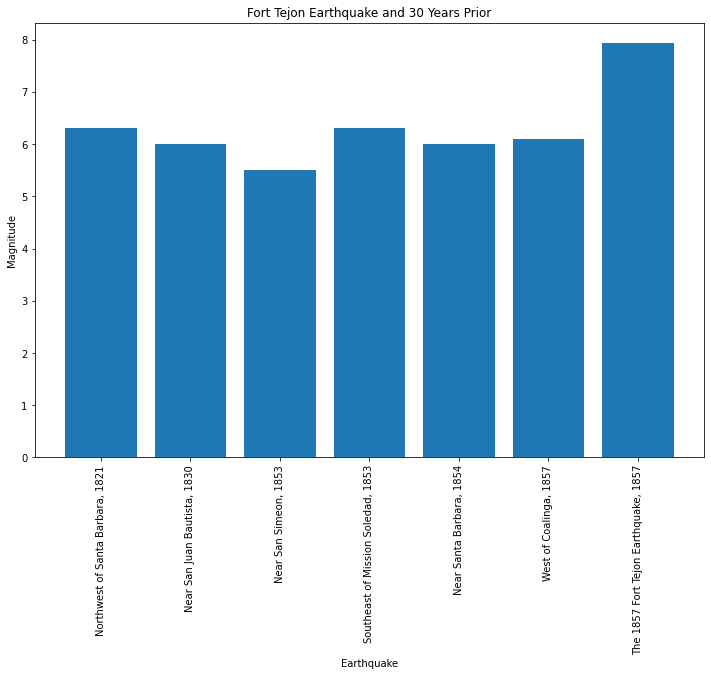

In [17]:
# Variables for Bar Chart
eq_locs = fort_tejon_bar['Earthquake']
eq_mag = fort_tejon_bar['Magnitude']

# Plotting
plt.figure(figsize=(12,8))
plt.bar(eq_locs, eq_mag)
plt.xticks(rotation=90)
plt.title('Fort Tejon Earthquake and 30 Years Prior')
plt.ylabel('Magnitude')
plt.xlabel('Earthquake')
plt.show()

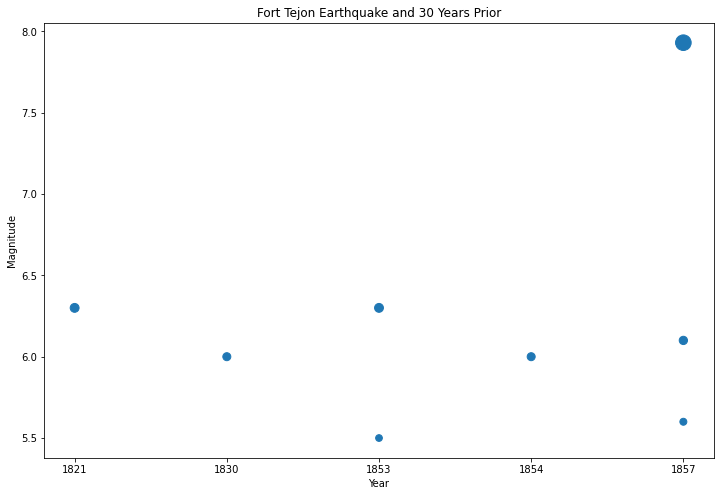

In [15]:
# Scatter DF
fort_tejon_scatter = fort_tejon_bar
fort_tejon_scatter['Time'] = fort_tejon_dirty['Year']

# Variables for Scatter Plot
eq_locs = fort_tejon_scatter['Earthquake']
eq_mag = fort_tejon_scatter['Magnitude'] 
magsize = [1*2**n for n in eq_mag]
eq_time = fort_tejon_scatter['Time']

# Scatter Plot
plt.figure(figsize=(12,8))
plt.scatter(eq_time, eq_mag, s=magsize)
plt.title('Fort Tejon Earthquake and 30 Years Prior')
plt.ylabel('Magnitude')
plt.xlabel('Year')
plt.show()